# Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Network_Traffic_data.csv')


Mounted at /content/drive


# Preview of first few rows from the dataset

In [3]:
print("Columns in CSV:", df.columns)
df.head()


Columns in CSV: Index(['Time', 'Source', 'No.', 'Destination', 'Protocol', 'Length', 'Info'], dtype='object')


,Time,Source,No.,Destination,Protocol,Length,Info
0,0.000000,192.167.8.166,1,192.167.255.255,NBNS,92,Name query NB WPAD<00>
1,0.784682,192.167.8.166,2,192.167.255.255,NBNS,92,Name query NB WPAD<00>
2,1.169060,VMware_8a:5c:e6,3,Broadcast,ARP,60,Who has 192.167.7.175? Tell 192.167.0.1
3,2.167949,VMware_8a:5c:e6,4,Broadcast,ARP,60,Who has 192.167.7.175? Tell 192.167.0.1
4,3.170095,VMware_8a:5c:e6,5,Broadcast,ARP,60,Who has 192.167.7.175? Tell 192.167.0.1


# KPSS Test

In [4]:
from statsmodels.tsa.stattools import kpss
import warnings
warnings.filterwarnings("ignore")

length_data = df['Length'].dropna()

# KPSS Test
statistic, p_value, lags, critical_values = kpss(length_data, regression='c')

print(f"KPSS Test Statistic: {statistic}")
print(f"p-value: {p_value}")
print(f"Lags used: {lags}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key} : {value}")

# Result interpretation
if p_value < 0.05:
    print("\nResult: Reject the null hypothesis — the series is **not stationary**.")
else:
    print("\nResult: Fail to reject the null — the series is **stationary**.")


KPSS Test Statistic: 16.493559414434262
p-value: 0.01
Lags used: 300
Critical Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739

Result: Reject the null hypothesis — the series is **not stationary**.


# ACF Plot

<Figure size 3000x500 with 0 Axes>

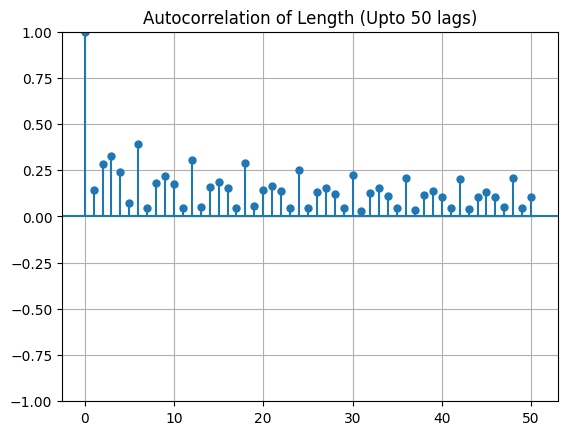

In [5]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

length_series = df['Length'].dropna()

# Plot autocorrelation
plt.figure(figsize=(30, 5))
plot_acf(length_series, lags=50)
plt.title('Autocorrelation of Length (Upto 50 lags)')
plt.grid(True)
plt.show()


# PACF Plot

<Figure size 3000x500 with 0 Axes>

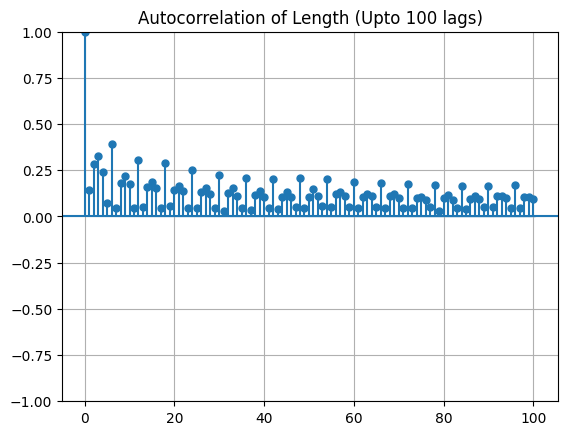

In [6]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

length_series = df['Length'].dropna()

# Plot autocorrelation
plt.figure(figsize=(30, 5))
plot_acf(length_series, lags=100)
plt.title('Autocorrelation of Length (Upto 100 lags)')
plt.grid(True)
plt.show()


# ACF Plot upto 300 lags

<Figure size 3000x500 with 0 Axes>

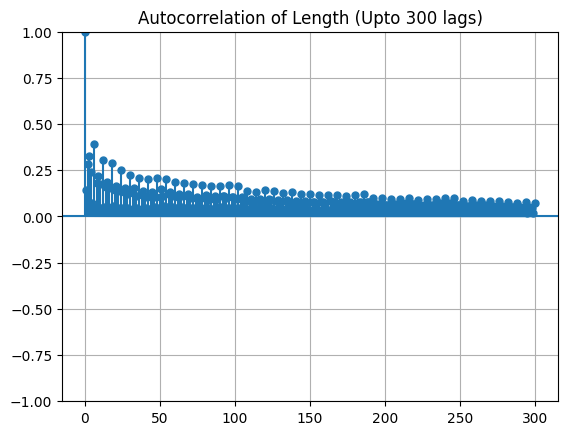

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

length_series = df['Length'].dropna()

# Plot autocorrelation
plt.figure(figsize=(30, 5))
plot_acf(length_series, lags=300)
plt.title('Autocorrelation of Length (Upto 300 lags)')
plt.grid(True)
plt.show()


# Sample variance instability test

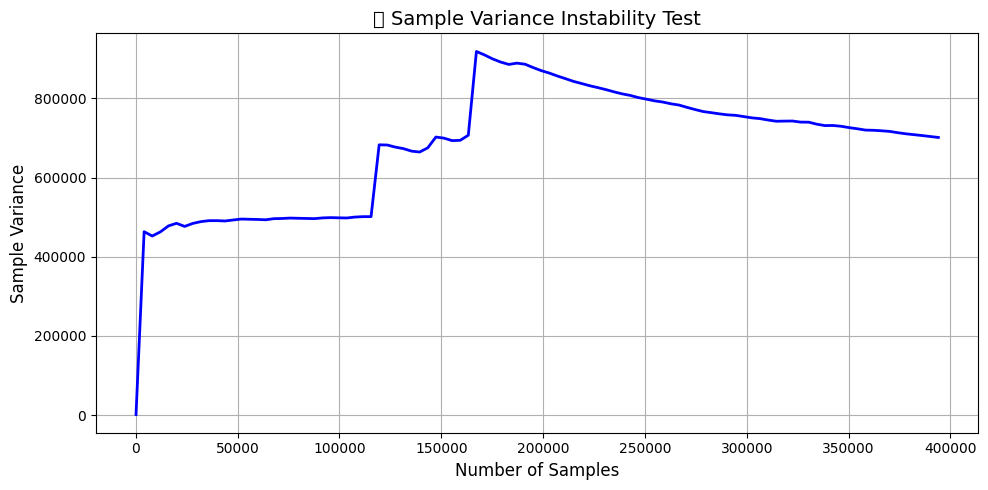

In [9]:
data = df['Length'].dropna().values
window_sizes = np.linspace(100, len(data), 100, dtype=int)
sample_variances = [np.var(data[:n]) for n in window_sizes]

plt.figure(figsize=(10, 5))
plt.plot(window_sizes, sample_variances, color='blue', linewidth=2)
plt.title("📊 Sample Variance Instability Test", fontsize=14)
plt.xlabel("Number of Samples", fontsize=12)
plt.ylabel("Sample Variance", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# PACF Plot upto 100 lags

<Figure size 1200x600 with 0 Axes>

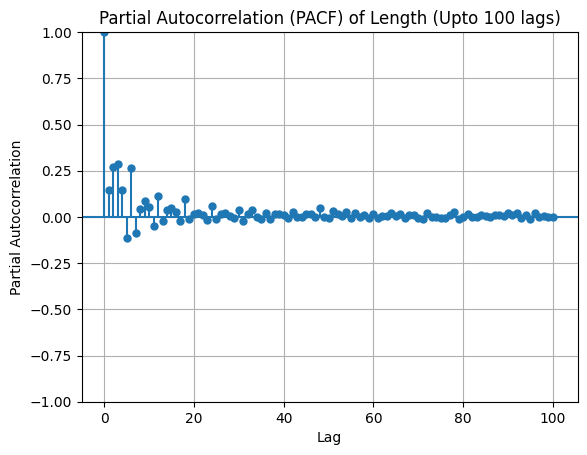

In [10]:
!pip install statsmodels

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

data = df['Length'].dropna()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(data, lags=100, method='ywm')  # You can try 'ols', 'ywun', 'ywm', etc.
plt.title('Partial Autocorrelation (PACF) of Length (Upto 100 lags)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

# Estimation of alpha

In [11]:
import numpy as np
from scipy.stats import norm
data = df['Length'].dropna().values

def regression_type_alpha_estimator(data):
    N = len(data)
    sorted_data = np.sort(np.abs(data))
    p = np.linspace(1/(N+1), N/(N+1), N)
    q = norm.ppf((1 + p) / 2)  # quantiles
    log_q = np.log(q)
    log_data = np.log(sorted_data)

    # Linear regression: log|X| ~ log(q)
    coeffs = np.polyfit(log_q, log_data, 1)
    slope = coeffs[0]

    # α is approximately 1/slope
    alpha_est = 1 / slope
    return round(alpha_est, 3)

alpha = regression_type_alpha_estimator(data)
print("Estimated α (regression-type):", alpha)

Estimated α (regression-type): 0.889


# Making the dataset stationary

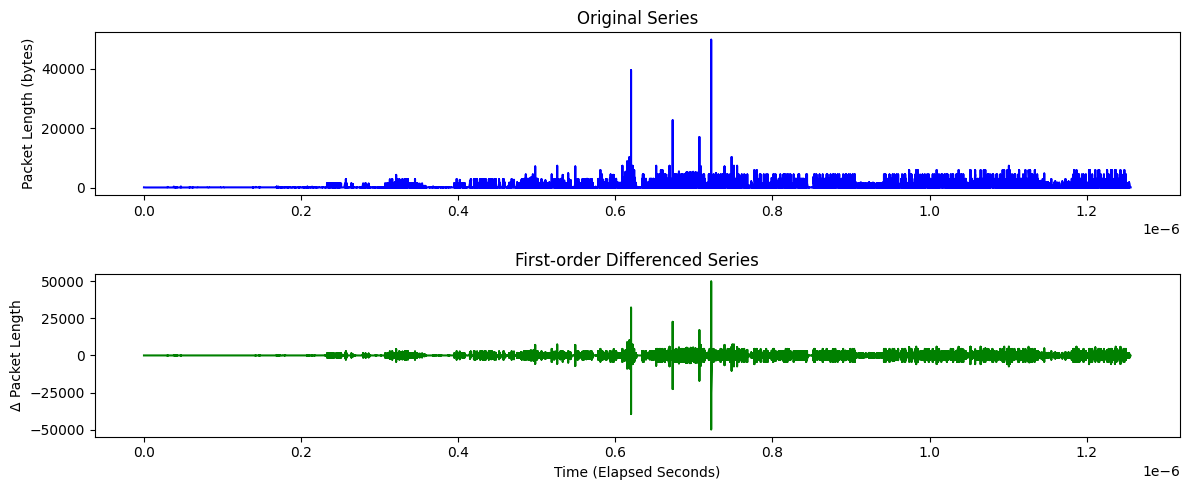

KPSS Statistic: 0.0037036111759146976
p-value: 0.1
✅ Series is likely stationary (fail to reject H0).


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

df['Time'] = pd.to_datetime(df['Time'])
df = df.sort_values('Time')
df['elapsed_seconds'] = (df['Time'] - df['Time'].iloc[0]).dt.total_seconds()
df.set_index('elapsed_seconds', inplace=True)

# Extract the target series
ts = df['Length']

# Apply first-order differencing
ts_diff = ts.diff().dropna()

# Plot original vs differenced series
plt.figure(figsize=(12, 5))

plt.subplot(2, 1, 1)
plt.plot(ts, color='blue')
plt.title('Original Series')
plt.ylabel('Packet Length (bytes)')

plt.subplot(2, 1, 2)
plt.plot(ts_diff, color='green')
plt.title('First-order Differenced Series')
plt.xlabel('Time (Elapsed Seconds)')
plt.ylabel('Δ Packet Length')

plt.tight_layout()
plt.show()

# Step 5: KPSS test
stat, p_value, lags, crit = kpss(ts_diff, regression='c', nlags="auto")
print("KPSS Statistic:", stat)
print("p-value:", p_value)
if p_value > 0.05:
    print("✅ Series is likely stationary (fail to reject H0).")
else:
    print("⚠️ Series may still be non-stationary (reject H0).")


In [17]:
ts_stationary = ts.diff().dropna()

# Check for symmetric alpha stable

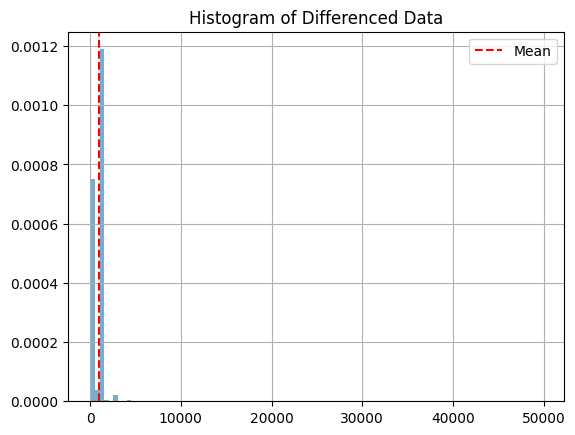

In [14]:
plt.hist(data, bins=100, density=True, alpha=0.6)
plt.axvline(np.mean(data), color='red', linestyle='--', label='Mean')
plt.title("Histogram of Differenced Data")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
from scipy.stats import skew

skewness = skew(ts_stationary.values)
print(f"Sample Skewness: {skewness:.4f}")


Sample Skewness: -0.0035


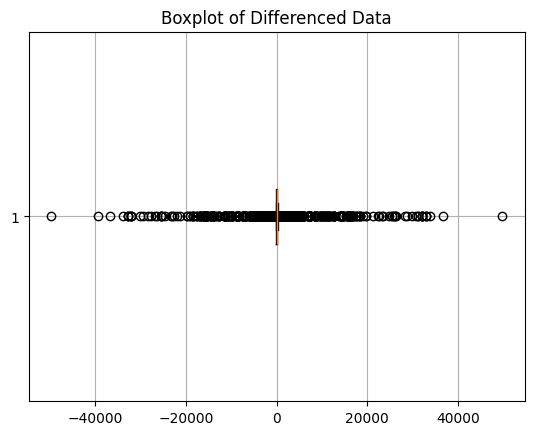

In [19]:
plt.boxplot(ts_stationary.values, vert=False)
plt.title('Boxplot of Differenced Data')
plt.grid(True)
plt.show()

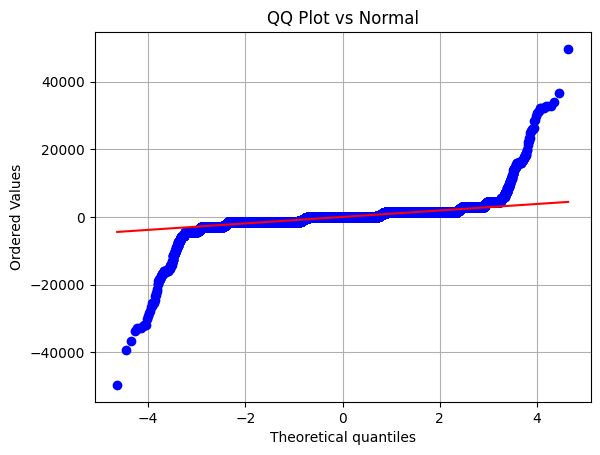

In [20]:
import scipy.stats as stats

stats.probplot(ts_stationary.values, dist="norm", plot=plt)
plt.title('QQ Plot vs Normal')
plt.grid(True)
plt.show()

In [21]:
np.mean(ts_stationary.values) - np.median(ts_stationary.values)

np.float64(1.5223210321336598e-05)

# Decomposition of time components

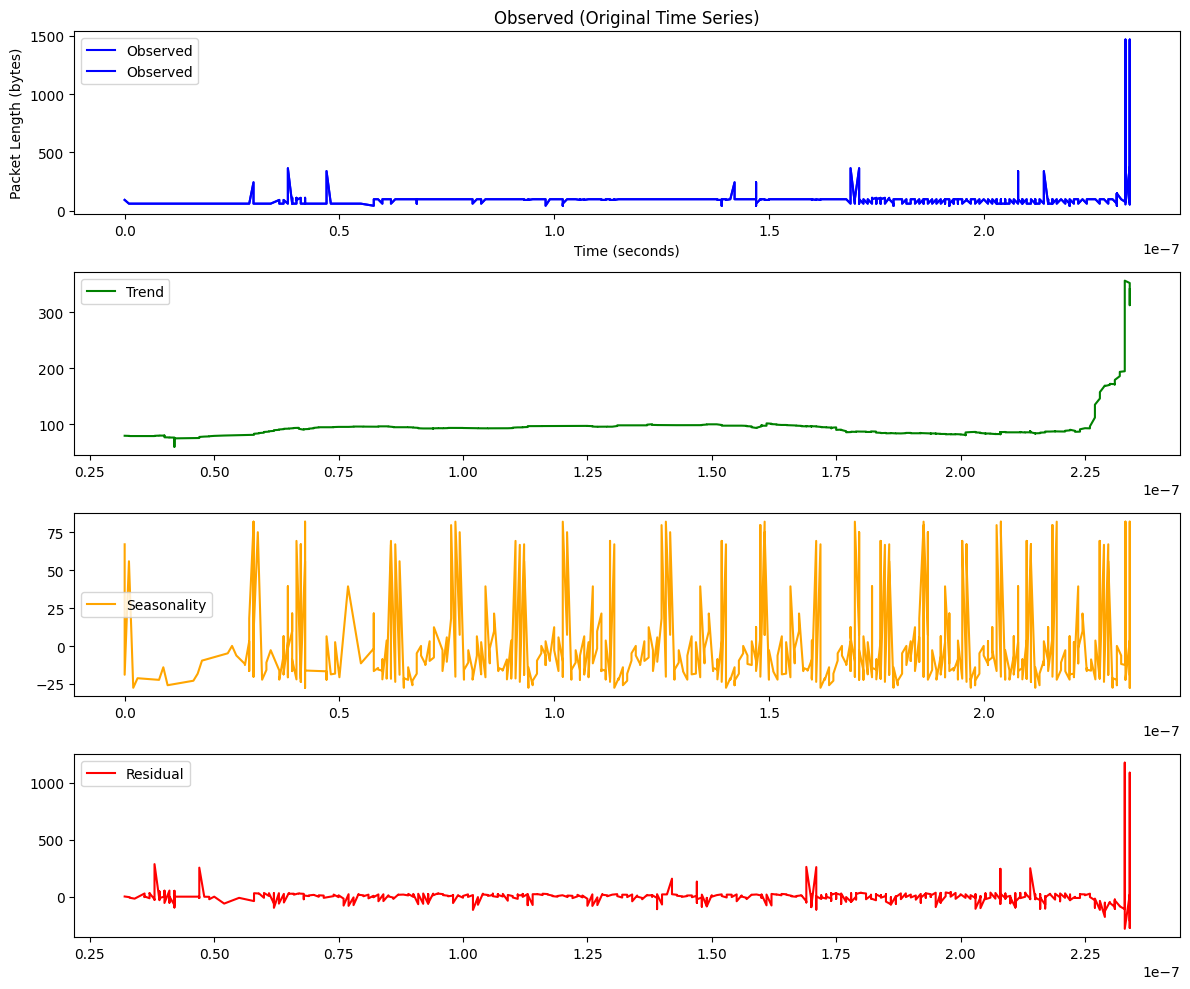

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Convert to datetime
df['Time'] = pd.to_datetime(df['Time'])
df = df.sort_values('Time')

# Convert to seconds since start
df['elapsed_seconds'] = (df['Time'] - df['Time'].iloc[0]).dt.total_seconds()

# Set seconds as index
df.set_index('elapsed_seconds', inplace=True)

# Use only the 'length' column for decomposition
length_series = df['Length']

# Ensure you have at least 2 * period data points
length_series = length_series.iloc[:1000]  # Trim or pad to ensure enough points

# Apply decomposition
decomposition = seasonal_decompose(length_series, model='additive', period=60)

# Plot components
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed', color='blue')
plt.legend()

plt.subplot(411)
plt.plot(decomposition.observed, label='Observed', color='blue')
plt.title('Observed (Original Time Series)')
plt.ylabel('Packet Length (bytes)')
plt.xlabel('Time (seconds)')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='green')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality', color='orange')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='red')
plt.legend()

plt.tight_layout()
plt.show()


# ARMA Model Fitting

# AIC Criterion to find the best order

In [23]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Smaller sample
ts_sample = ts_stationary.iloc[:1000]

# Reduced range
p = q = range(0, 3)
pq = list(itertools.product(p, q))

best_aic = float('inf')
best_order = None

warnings.filterwarnings("ignore")

for order in pq:
    try:
        model = ARIMA(ts_sample, order=(order[0], 0, order[1]))
        result = model.fit()
        if result.aic < best_aic:
            best_aic = result.aic
            best_order = order
    except:
        continue

print(f"Best (p, q) from sample: {best_order} with AIC: {best_aic}")


Best (p, q) from sample: (2, 1) with AIC: 11594.638671981982


In [27]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Fit the ARMA(2,1) model on the full stationary series
model = ARIMA(ts_stationary, order=(2, 0, 1))  # d=0 because differencing is already applied
result = model.fit()

# Print summary
print(result.summary())


                               SARIMAX Results                                
Dep. Variable:                 Length   No. Observations:               394135
Model:                 ARIMA(2, 0, 1)   Log Likelihood            -3186174.489
Date:                Mon, 28 Jul 2025   AIC                        6372358.978
Time:                        16:52:23   BIC                        6372413.400
Sample:                             0   HQIC                       6372374.538
                             - 394135                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1573      0.105      1.503      0.133      -0.048       0.362
ar.L1         -0.0516      0.000   -167.867      0.000      -0.052      -0.051
ar.L2          0.0530      0.000    158.307      0.0

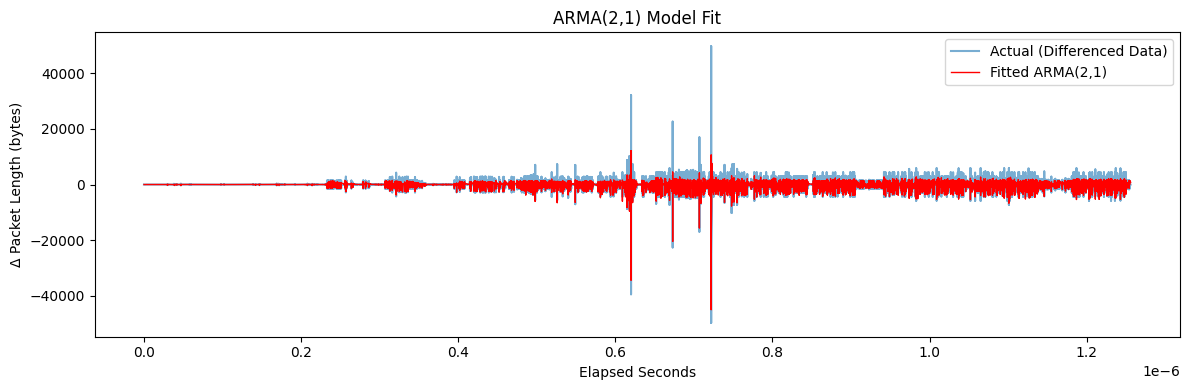

In [28]:
plt.figure(figsize=(12, 4))
plt.plot(ts_stationary, label='Actual (Differenced Data)', alpha=0.6)
plt.plot(result.fittedvalues, color='red', label='Fitted ARMA(2,1)', linewidth=1)
plt.title('ARMA(2,1) Model Fit')
plt.xlabel('Elapsed Seconds')
plt.ylabel('Δ Packet Length (bytes)')
plt.legend()
plt.tight_layout()
plt.show()

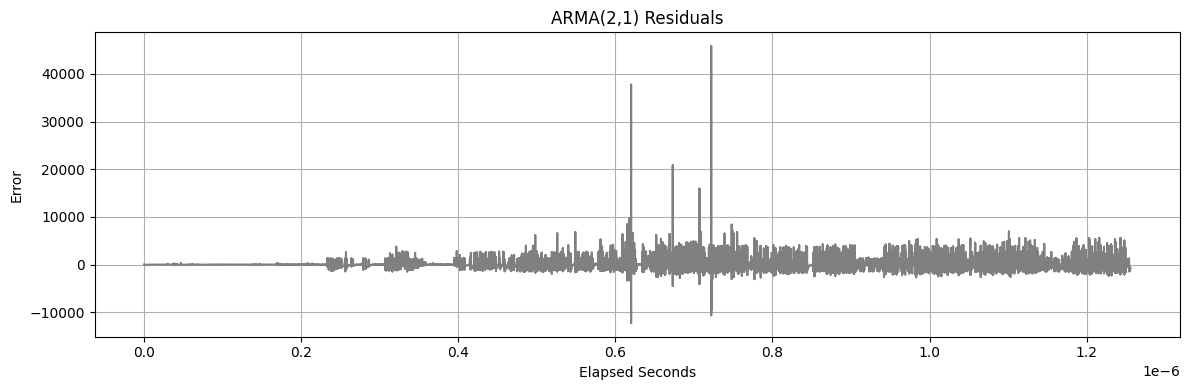

In [29]:
residuals = result.resid

plt.figure(figsize=(12, 4))
plt.plot(residuals, label='Residuals', color='gray')
plt.title('ARMA(2,1) Residuals')
plt.xlabel('Elapsed Seconds')
plt.ylabel('Error')
plt.grid(True)
plt.tight_layout()
plt.show()

# Classical Yule Walker model fit


Yule-Walker AR(2) Coefficients:
 [-0.76491731 -0.38862583]
Estimated Noise Variance (sigma^2): 845.80


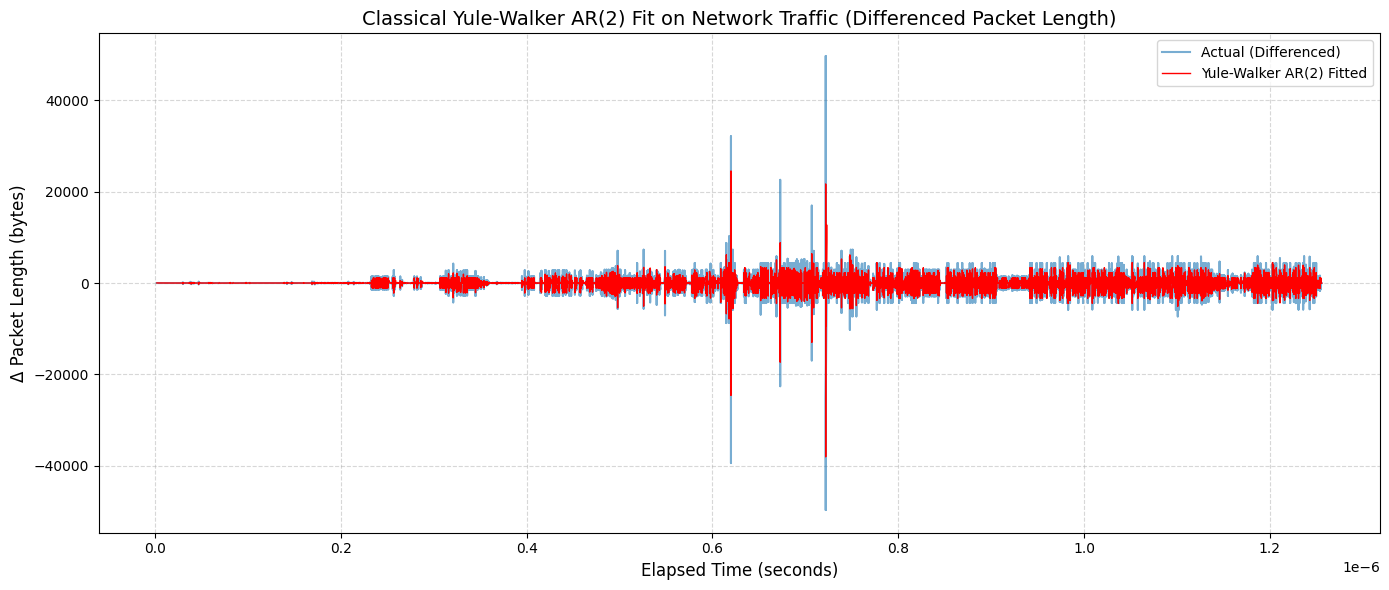

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import yule_walker

# ✅ ts_stationary is already computed earlier:
# ts = df['length']
# ts_stationary = ts.diff().dropna()

# Fit AR(p) using Classical Yule-Walker method
p = 2  # Use the same order as ARMA model (based on AIC)
rho, sigma = yule_walker(ts_stationary, order=p)

print(f"\nYule-Walker AR({p}) Coefficients:\n", rho)
print(f"Estimated Noise Variance (sigma^2): {sigma:.2f}")

# Generate fitted values using the AR coefficients
fitted_values = []

# Pad first p values with NaN
for i in range(p):
    fitted_values.append(np.nan)

ts_array = ts_stationary.values

for t in range(p, len(ts_array)):
    pred = sum(rho[i] * ts_array[t - i - 1] for i in range(p))
    fitted_values.append(pred)

# Create DataFrame for plotting
df_result = pd.DataFrame({
    'Actual': ts_stationary.values,
    'Fitted': fitted_values
}, index=ts_stationary.index).dropna()

# Plot Actual vs Fitted
plt.figure(figsize=(14, 6))
plt.plot(df_result.index, df_result['Actual'], label='Actual (Differenced)', alpha=0.6)
plt.plot(df_result.index, df_result['Fitted'], label='Yule-Walker AR(2) Fitted', color='red', linewidth=1)
plt.title('Classical Yule-Walker AR(2) Fit on Network Traffic (Differenced Packet Length)', fontsize=14)
plt.xlabel('Elapsed Time (seconds)', fontsize=12)
plt.ylabel('Δ Packet Length (bytes)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


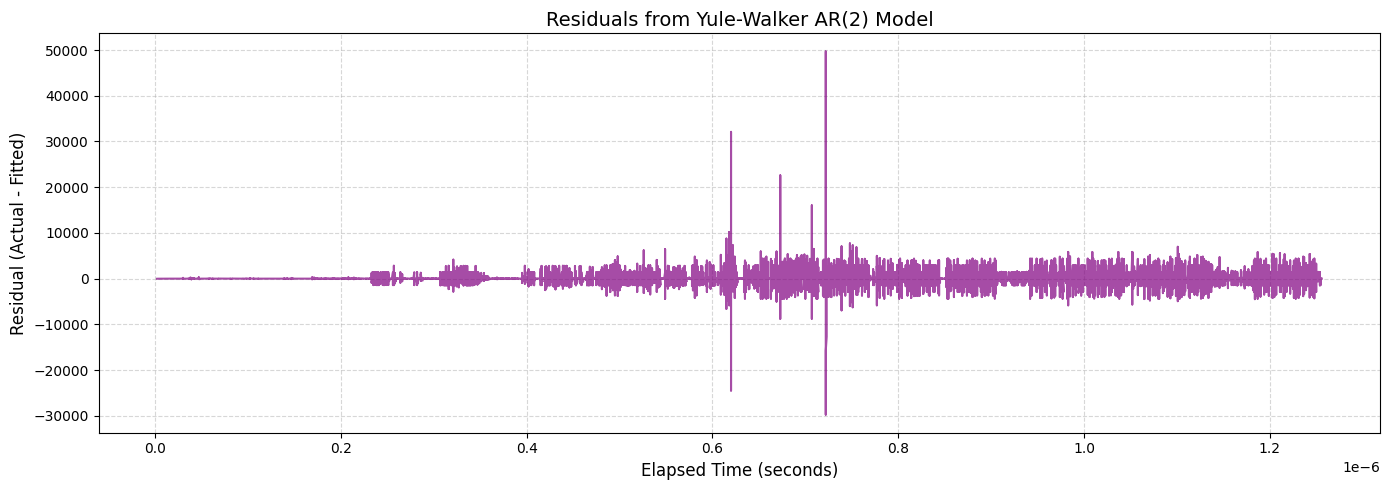

In [31]:
import matplotlib.pyplot as plt

# Compute residuals
residuals = df_result['Actual'] - df_result['Fitted']

# Plot residuals as a time series
plt.figure(figsize=(14, 5))
plt.plot(df_result.index, residuals, color='purple', alpha=0.7)
plt.title('Residuals from Yule-Walker AR(2) Model', fontsize=14)
plt.xlabel('Elapsed Time (seconds)', fontsize=12)
plt.ylabel('Residual (Actual - Fitted)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

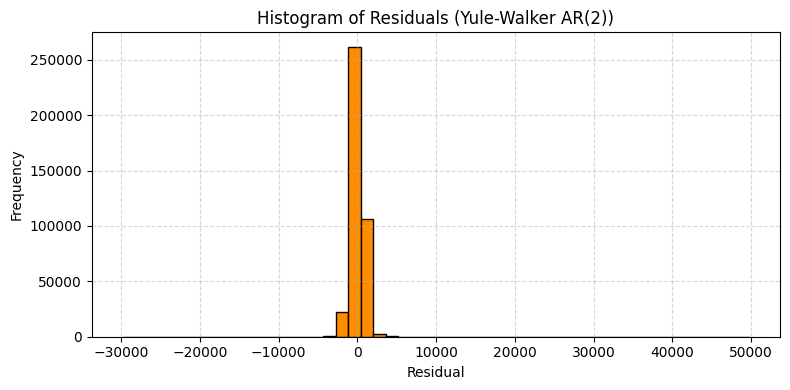

In [32]:
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=50, color='darkorange', edgecolor='black')
plt.title('Histogram of Residuals (Yule-Walker AR(2))')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Modified yule walker method for alpha stable using autocodifference

Modified Yule-Walker AR(2) coefficients (based on autocodifference):
[0.73030259 1.        ]


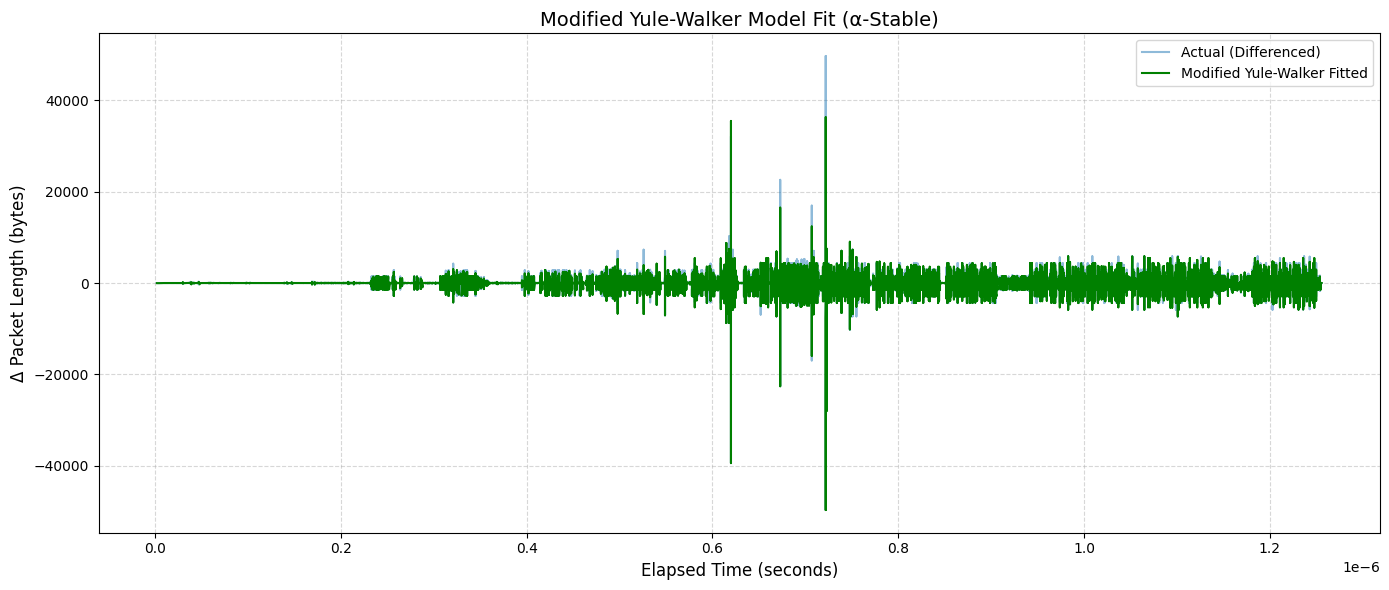

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# Estimate the autocodifference function
def autocodifference(x, lag=20):
    n = len(x)
    mean = np.mean(x)
    codiff = []
    for h in range(lag + 1):
        diff = x[h:] - x[:n - h]
        codiff.append(np.mean(np.abs(diff - np.mean(diff))))
    return np.array(codiff)

# Compute autocodifference and construct coefficient matrix
p = 2  # You can use the same p from AIC-based ARMA model
codiff_vals = autocodifference(ts_stationary.values, lag=p)

# Build Toeplitz matrix for modified Yule-Walker equations
from scipy.linalg import toeplitz

R = toeplitz(codiff_vals[:-1])   # (p x p) matrix
r = codiff_vals[1:]              # (p x 1) vector

# Solve for AR coefficients
phi = np.linalg.solve(R, r)

print(f"Modified Yule-Walker AR({p}) coefficients (based on autocodifference):\n{phi}")

# Forecast using modified coefficients
fitted_values = []

# pad with NaN for first p values
for i in range(p):
    fitted_values.append(np.nan)

ts_array = ts_stationary.values

for t in range(p, len(ts_array)):
    pred = sum(phi[i] * ts_array[t - i - 1] for i in range(p))
    fitted_values.append(pred)

# Plot original vs fitted values
import pandas as pd
df_mod_yw = pd.DataFrame({
    'Actual': ts_stationary.values,
    'Fitted': fitted_values
}, index=ts_stationary.index).dropna()

plt.figure(figsize=(14, 6))
plt.plot(df_mod_yw.index, df_mod_yw['Actual'], label='Actual (Differenced)', alpha=0.5)
plt.plot(df_mod_yw.index, df_mod_yw['Fitted'], label='Modified Yule-Walker Fitted', color='green')
plt.title('Modified Yule-Walker Model Fit (α-Stable)', fontsize=14)
plt.xlabel('Elapsed Time (seconds)', fontsize=12)
plt.ylabel('Δ Packet Length (bytes)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


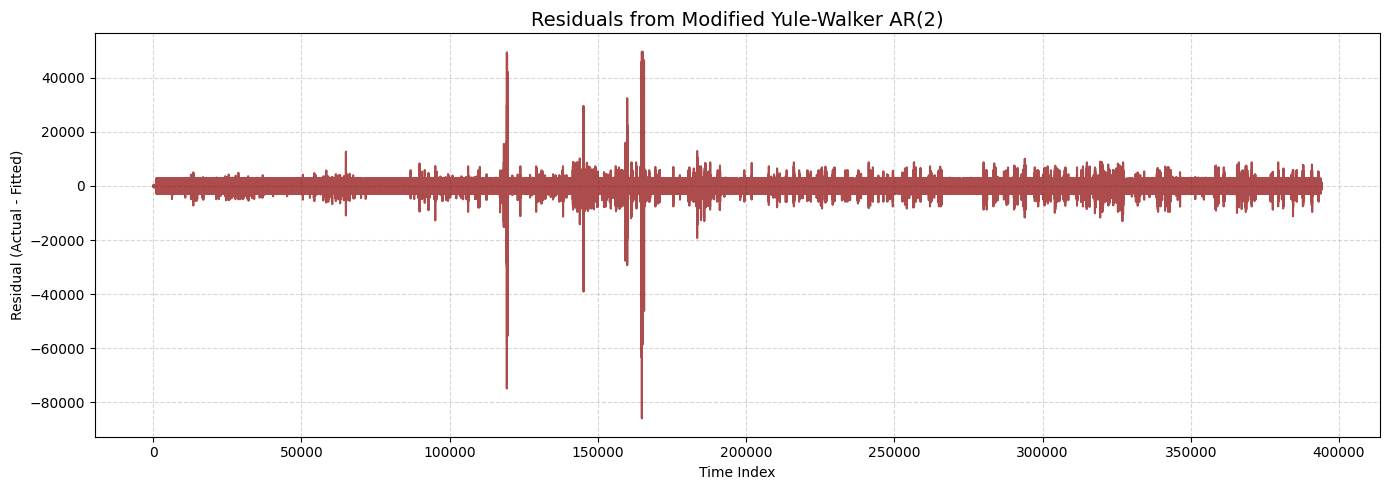

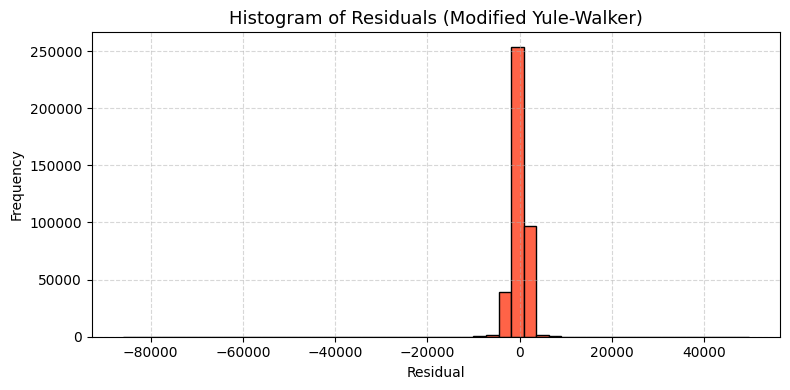

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert fitted_values list to array
fitted_array = np.array(fitted_values)

# Drop NaNs for alignment with ts_stationary
valid_index = ~np.isnan(fitted_array)
actual_aligned = ts_stationary.values[valid_index]
fitted_aligned = fitted_array[valid_index]

# Compute residuals
residuals = actual_aligned - fitted_aligned

# Create DataFrame (optional, for clarity)
df_residuals_mod_yw = pd.DataFrame({
    'Actual': actual_aligned,
    'Fitted': fitted_aligned,
    'Residual': residuals
})

# Plot residual time series
plt.figure(figsize=(14, 5))
plt.plot(df_residuals_mod_yw['Residual'], color='darkred', alpha=0.7)
plt.title('Residuals from Modified Yule-Walker AR(2)', fontsize=14)
plt.xlabel('Time Index')
plt.ylabel('Residual (Actual - Fitted)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Histogram of residuals
plt.figure(figsize=(8, 4))
plt.hist(df_residuals_mod_yw['Residual'], bins=50, color='tomato', edgecolor='black')
plt.title('Histogram of Residuals (Modified Yule-Walker)', fontsize=13)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
